# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f2b8db48bc6040610b39caab8a985d978e1c3af8b230467d5760b0a13e950e7f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve,classification_report, confusion_matrix

import gensim
from gensim.models import Word2Vec
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-10-02 04:01:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip.1’

smsspamcollection.z     [  <=>               ] 198.65K   804KB/s    in 0.2s    

2024-10-02 04:01:47 (804 KB/s) - ‘smsspamcollection.zip.1’ saved [203415]

Archive:  smsspamcollection.zip
replace SMSSpamCollection? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace readme? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

,count
target,
ham,0.865937
spam,0.134063


In [ ]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [ ]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [ ]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [ ]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [ ]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

In [ ]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_counts, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test_counts)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.9694976076555024
Precision: 1.0
Recall: 0.7723214285714286
F1 Score: 0.871536523929471


In [ ]:
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       1.00      0.77      0.87       224

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672



In [ ]:
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1448    0]
 [  51  173]]


# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [ ]:
X = df['clean_text']
y = df['target'].map({'ham':0, 'spam':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test_tfidf)

In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.972488038277512
Precision: 1.0
Recall: 0.7946428571428571
F1 Score: 0.8855721393034826


In [ ]:
print('\nClassification Report:\n', classification_report(y_test, y_pred))

print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1448
           1       1.00      0.79      0.89       224

    accuracy                           0.97      1672
   macro avg       0.98      0.90      0.93      1672
weighted avg       0.97      0.97      0.97      1672

Confusion Matrix:
 [[1448    0]
 [  46  178]]


# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

In [ ]:
X = df['clean_text']
y = df['target'].map({'ham':0, 'spam':1})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# JUSTIFICACION SELECCION DEL MODELO

1. La elección de Support Vector Machine (SVM) para la clasificación binaria de
mensajes SMS en ham y spam se basa en que los datos textuales, al ser vectorizados con TfidfVectorizer, generan espacios de alta dimensionalidad. SVM maneja eficientemente esta complejidad al utilizar márgenes máximos para separar las clases, lo que mejora la capacidad de generalización del modelo y minimiza el riesgo de sobreajuste.

2. SVM es robusto frente a datos ruidosos y puede gestionar situaciones donde las clases no son linealmente separables. La flexibilidad de los kernels permite a SVM adaptarse a las complejidades inherentes de los datos textuales, capturando relaciones no lineales entre las características que otros modelos podrían no detectar. En el contexto de la clasificación de spam, donde las diferencias entre mensajes legítimos y no deseados pueden ser sutiles y variadas, esta capacidad de adaptación es crucial para lograr una alta precisión.

3. SVM demuestra un rendimiento superior en tareas de clasificación de texto en comparación con otros algoritmos de aprendizaje automático, ofreciendo una combinación óptima de precisión, eficiencia y robustez. Su habilidad para enfocarse en vectores de soporte críticos facilita un rendimiento consistente incluso en conjuntos de datos desbalanceados, comunes en la clasificación de spam.

In [ ]:
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train_tfidf, y_train)

SVC(kernel='linear', random_state=42)

In [ ]:
y_pred = clf.predict(X_test_tfidf)

In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))

Accuracy: 0.9844497607655502
Precision: 0.9852941176470589
Recall: 0.8973214285714286
F1 Score: 0.9392523364485982


In [ ]:
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.99      0.90      0.94       224

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672



In [ ]:
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1445    3]
 [  23  201]]


# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

X = df['clean_text']
y = df['target'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4, seed=42)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_vectors = np.array([vectorize(sentence) for sentence in X_train])
X_test_vectors = np.array([vectorize(sentence) for sentence in X_test])

In [ ]:
# Random Forest Classifier (for comparison)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_vectors, y_train)
y_pred_rf = rf_clf.predict(X_test_vectors)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print('Random Forest Classifier')
print('Accuracy:', rf_acc)
print('F1 Score:', rf_f1)
print('Classification Report:\n', classification_report(y_test, y_pred_rf))
print('-------------------------------------------')

Random Forest Classifier
Accuracy: 0.9294258373205742
F1 Score: 0.6467065868263473
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1448
           1       0.98      0.48      0.65       224

    accuracy                           0.93      1672
   macro avg       0.95      0.74      0.80      1672
weighted avg       0.93      0.93      0.92      1672

-------------------------------------------


# Justificacion eleccion del modelo

1. La elección de XGBoost para la clasificación binaria de mensajes SMS en categorías de ham  y spam se justifica por varias razones clave que destacan su efectividad y eficiencia en tareas de aprendizaje automático. XGBoost es una implementación optimizada de los árboles de decisión en ensamble, específicamente del algoritmo de Gradient Boosting, lo que le permite manejar de manera efectiva datos de alta dimensionalidad generados por técnicas de vectorización como CountVectorizer o TfidfVectorizer.

2. Una de las principales ventajas de XGBoost es su capacidad para capturar relaciones complejas y no lineales entre las características, lo que es fundamental en la clasificación de spam donde las diferencias entre mensajes legítimos y no deseados pueden ser sutiles y multifacéticas. Además, XGBoost incorpora regularización tanto L1 como L2, lo que ayuda a prevenir el sobreajuste y mejora la generalización del modelo a datos no vistos.

3. Otro aspecto destacado es su eficiencia computacional. XGBoost está diseñado para ser altamente eficiente en términos de tiempo de entrenamiento y uso de memoria, lo que lo hace adecuado para manejar grandes conjuntos de datos. Además, ofrece capacidades avanzadas de manejo de datos faltantes y paralelización, lo que optimiza aún más el proceso de entrenamiento.

In [ ]:
# XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_vectors, y_train)
y_pred_xgb = xgb_clf.predict(X_test_vectors)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print('XGBoost Classifier')
print('Accuracy:', xgb_acc)
print('F1 Score:', xgb_f1)
print('Classification Report:\n', classification_report(y_test, y_pred_xgb))

XGBoost Classifier
Accuracy: 0.9324162679425837
F1 Score: 0.7064935064935065
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1448
           1       0.84      0.61      0.71       224

    accuracy                           0.93      1672
   macro avg       0.89      0.79      0.83      1672
weighted avg       0.93      0.93      0.93      1672



parameter variation: `vector_size`

In [ ]:
vector_sizes = [50, 100, 150, 200]
rf_accuracies = []
rf_f1_scores = []
xgb_accuracies = []
xgb_f1_scores = []

Vector Size: 50
Random Forest - Accuracy: 0.9264354066985646 F1 Score: 0.6371681415929203
XGBoost       - Accuracy: 0.9288277511961722 F1 Score: 0.6876640419947506
-------------------------------------------
Vector Size: 100
Random Forest - Accuracy: 0.93122009569378 F1 Score: 0.6627565982404692
XGBoost       - Accuracy: 0.937799043062201 F1 Score: 0.7305699481865285
-------------------------------------------
Vector Size: 150
Random Forest - Accuracy: 0.9336124401913876 F1 Score: 0.6744868035190615
XGBoost       - Accuracy: 0.9413875598086124 F1 Score: 0.7379679144385026
-------------------------------------------
Vector Size: 200
Random Forest - Accuracy: 0.9354066985645934 F1 Score: 0.686046511627907
XGBoost       - Accuracy: 0.9533492822966507 F1 Score: 0.7989690721649485
-------------------------------------------


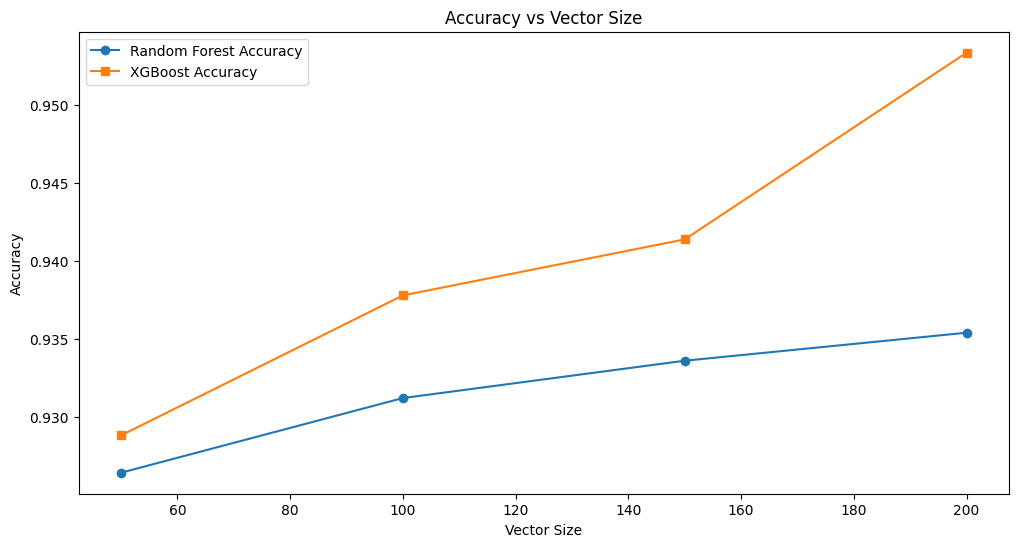

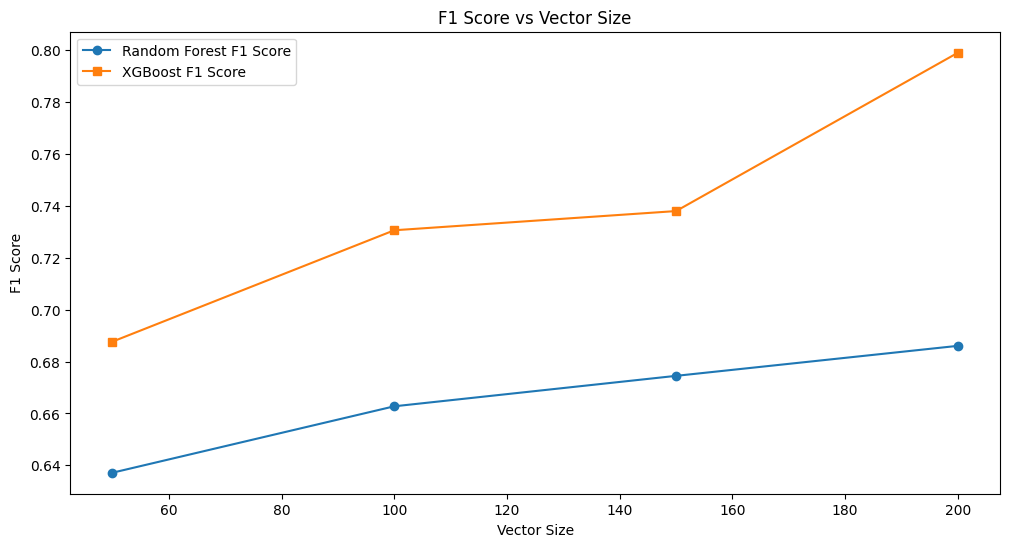

In [ ]:
for size in vector_sizes:

    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=size, window=5, negative=20, min_count=1, workers=4, seed=42)


    def vectorize(sentence):
        words = sentence.split()
        words_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(words_vecs) == 0:
            return np.zeros(size)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)

    X_train_vectors = np.array([vectorize(sentence) for sentence in X_train])
    X_test_vectors = np.array([vectorize(sentence) for sentence in X_test])

    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_vectors, y_train)
    y_pred_rf = rf_clf.predict(X_test_vectors)
    rf_acc = accuracy_score(y_test, y_pred_rf)
    rf_f1 = f1_score(y_test, y_pred_rf)
    rf_accuracies.append(rf_acc)
    rf_f1_scores.append(rf_f1)

    # XGBoost Classifier
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_clf.fit(X_train_vectors, y_train)
    y_pred_xgb = xgb_clf.predict(X_test_vectors)
    xgb_acc = accuracy_score(y_test, y_pred_xgb)
    xgb_f1 = f1_score(y_test, y_pred_xgb)
    xgb_accuracies.append(xgb_acc)
    xgb_f1_scores.append(xgb_f1)

    print(f"Vector Size: {size}")
    print('Random Forest - Accuracy:', rf_acc, 'F1 Score:', rf_f1)
    print('XGBoost       - Accuracy:', xgb_acc, 'F1 Score:', xgb_f1)
    print('-------------------------------------------')

# Plotting the performance vs vector_size
plt.figure(figsize=(12,6))
plt.plot(vector_sizes, rf_accuracies, marker='o', label='Random Forest Accuracy')
plt.plot(vector_sizes, xgb_accuracies, marker='s', label='XGBoost Accuracy')
plt.title('Accuracy vs Vector Size')
plt.xlabel('Vector Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(vector_sizes, rf_f1_scores, marker='o', label='Random Forest F1 Score')
plt.plot(vector_sizes, xgb_f1_scores, marker='s', label='XGBoost F1 Score')
plt.title('F1 Score vs Vector Size')
plt.xlabel('Vector Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


parameter variation: `window`

In [ ]:
window_sizes = [2, 5, 10]
rf_accuracies = []
rf_f1_scores = []
xgb_accuracies = []
xgb_f1_scores = []

Window Size: 2
Random Forest - Accuracy: 0.9090909090909091 F1 Score: 0.4899328859060403
XGBoost       - Accuracy: 0.9246411483253588 F1 Score: 0.64
-------------------------------------------
Window Size: 5
Random Forest - Accuracy: 0.9294258373205742 F1 Score: 0.650887573964497
XGBoost       - Accuracy: 0.9360047846889952 F1 Score: 0.7291139240506329
-------------------------------------------
Window Size: 10
Random Forest - Accuracy: 0.9431818181818182 F1 Score: 0.7382920110192838
XGBoost       - Accuracy: 0.9485645933014354 F1 Score: 0.7881773399014779
-------------------------------------------


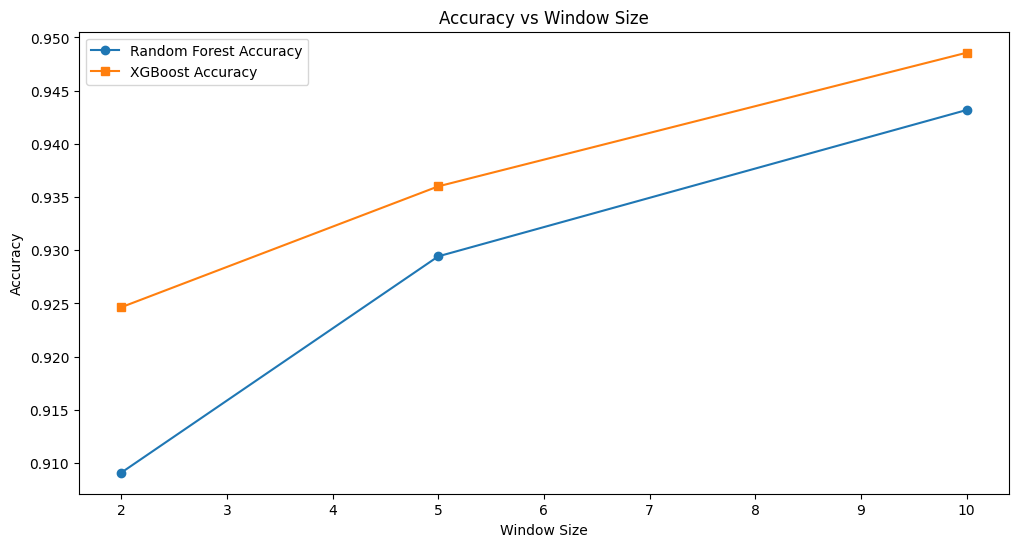

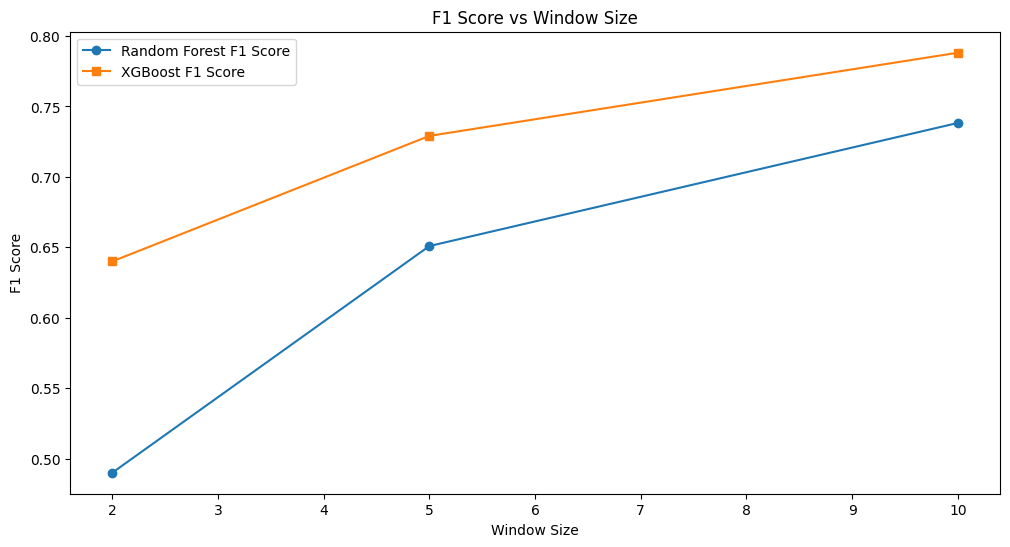

In [ ]:
for window in window_sizes:

    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=100, window=window, negative=20, min_count=1, workers=4, seed=42)

    def vectorize(sentence):
        words = sentence.split()
        words_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)

    X_train_vectors = np.array([vectorize(sentence) for sentence in X_train])
    X_test_vectors = np.array([vectorize(sentence) for sentence in X_test])

    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_vectors, y_train)
    y_pred_rf = rf_clf.predict(X_test_vectors)
    rf_acc = accuracy_score(y_test, y_pred_rf)
    rf_f1 = f1_score(y_test, y_pred_rf)
    rf_accuracies.append(rf_acc)
    rf_f1_scores.append(rf_f1)

    # XGBoost Classifier
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_clf.fit(X_train_vectors, y_train)
    y_pred_xgb = xgb_clf.predict(X_test_vectors)
    xgb_acc = accuracy_score(y_test, y_pred_xgb)
    xgb_f1 = f1_score(y_test, y_pred_xgb)
    xgb_accuracies.append(xgb_acc)
    xgb_f1_scores.append(xgb_f1)

    print(f"Window Size: {window}")
    print('Random Forest - Accuracy:', rf_acc, 'F1 Score:', rf_f1)
    print('XGBoost       - Accuracy:', xgb_acc, 'F1 Score:', xgb_f1)
    print('-------------------------------------------')

plt.figure(figsize=(12,6))
plt.plot(window_sizes, rf_accuracies, marker='o', label='Random Forest Accuracy')
plt.plot(window_sizes, xgb_accuracies, marker='s', label='XGBoost Accuracy')
plt.title('Accuracy vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(window_sizes, rf_f1_scores, marker='o', label='Random Forest F1 Score')
plt.plot(window_sizes, xgb_f1_scores, marker='s', label='XGBoost F1 Score')
plt.title('F1 Score vs Window Size')
plt.xlabel('Window Size')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

parameter variation: `negative`

In [ ]:
negative_samples = [5, 10, 15, 20]
rf_accuracies = []
rf_f1_scores = []
xgb_accuracies = []
xgb_f1_scores = []

Negative Sampling: 5
Random Forest - Accuracy: 0.9222488038277512 F1 Score: 0.59375
XGBoost       - Accuracy: 0.9389952153110048 F1 Score: 0.7228260869565217
-------------------------------------------
Negative Sampling: 10
Random Forest - Accuracy: 0.9144736842105263 F1 Score: 0.5372168284789643
XGBoost       - Accuracy: 0.9258373205741627 F1 Score: 0.6536312849162011
-------------------------------------------
Negative Sampling: 15
Random Forest - Accuracy: 0.937200956937799 F1 Score: 0.6991404011461319
XGBoost       - Accuracy: 0.9419856459330144 F1 Score: 0.7568922305764411
-------------------------------------------
Negative Sampling: 20
Random Forest - Accuracy: 0.9258373205741627 F1 Score: 0.6219512195121951
XGBoost       - Accuracy: 0.9401913875598086 F1 Score: 0.7422680412371134
-------------------------------------------


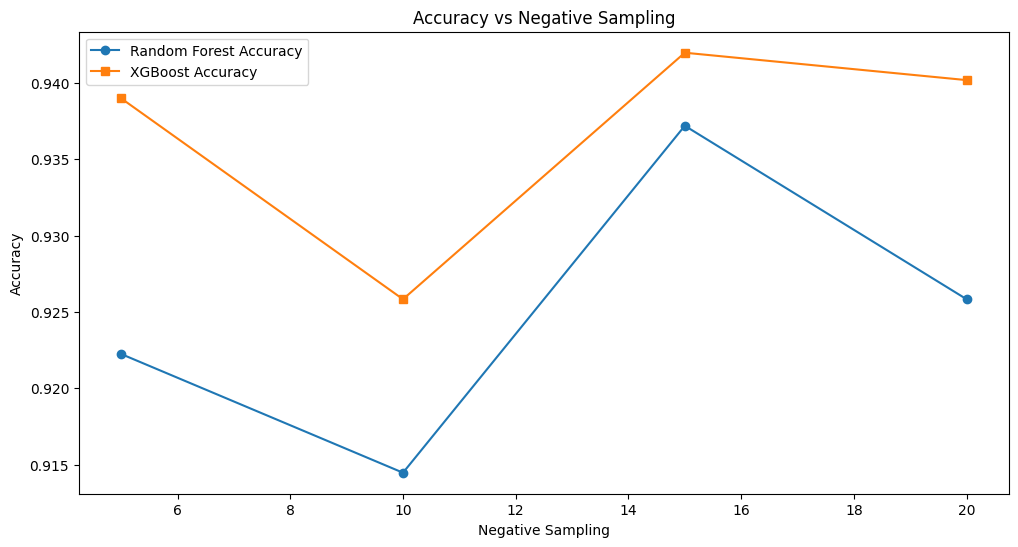

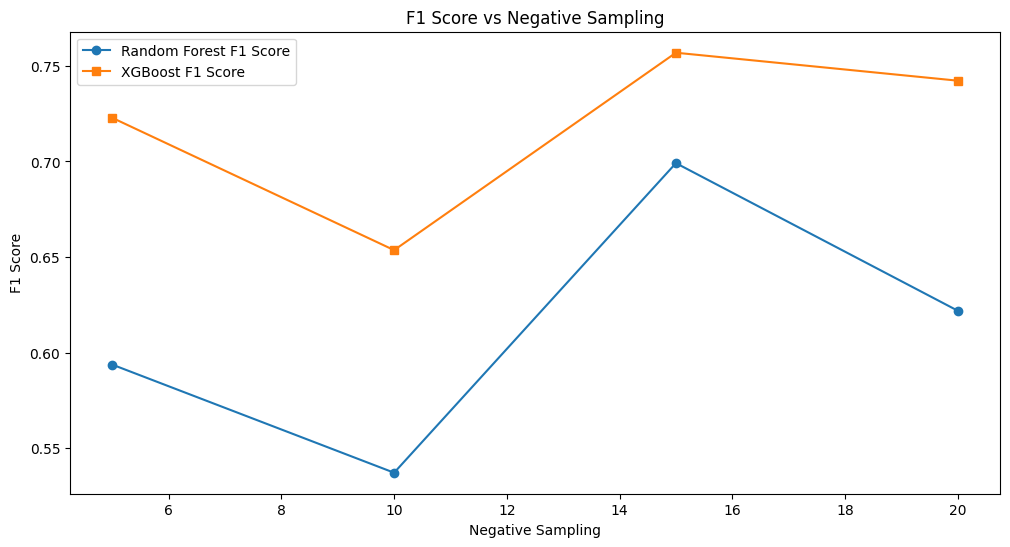

In [ ]:
for negative in negative_samples:

    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=100, window=5, negative=negative, min_count=1, workers=4, seed=42)


    def vectorize(sentence):
        words = sentence.split()
        words_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)

    X_train_vectors = np.array([vectorize(sentence) for sentence in X_train])
    X_test_vectors = np.array([vectorize(sentence) for sentence in X_test])

    # Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(X_train_vectors, y_train)
    y_pred_rf = rf_clf.predict(X_test_vectors)
    rf_acc = accuracy_score(y_test, y_pred_rf)
    rf_f1 = f1_score(y_test, y_pred_rf)
    rf_accuracies.append(rf_acc)
    rf_f1_scores.append(rf_f1)

    # XGBoost Classifier
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb_clf.fit(X_train_vectors, y_train)
    y_pred_xgb = xgb_clf.predict(X_test_vectors)
    xgb_acc = accuracy_score(y_test, y_pred_xgb)
    xgb_f1 = f1_score(y_test, y_pred_xgb)
    xgb_accuracies.append(xgb_acc)
    xgb_f1_scores.append(xgb_f1)

    print(f"Negative Sampling: {negative}")
    print('Random Forest - Accuracy:', rf_acc, 'F1 Score:', rf_f1)
    print('XGBoost       - Accuracy:', xgb_acc, 'F1 Score:', xgb_f1)
    print('-------------------------------------------')

plt.figure(figsize=(12,6))
plt.plot(negative_samples, rf_accuracies, marker='o', label='Random Forest Accuracy')
plt.plot(negative_samples, xgb_accuracies, marker='s', label='XGBoost Accuracy')
plt.title('Accuracy vs Negative Sampling')
plt.xlabel('Negative Sampling')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(negative_samples, rf_f1_scores, marker='o', label='Random Forest F1 Score')
plt.plot(negative_samples, xgb_f1_scores, marker='s', label='XGBoost F1 Score')
plt.title('F1 Score vs Negative Sampling')
plt.xlabel('Negative Sampling')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


Running best parameters `vector_size, window and negative` (All at the same time)

In [ ]:
best_vector_size = 150
best_window = 10
best_negative = 15

In [ ]:
sentences = [sentence.split() for sentence in X_train]
best_model = Word2Vec(sentences, vector_size=best_vector_size, window=best_window, negative=best_negative, min_count=1, workers=4, seed=42)


def vectorize(sentence):
    words = sentence.split()
    words_vecs = [best_model.wv[word] for word in words if word in best_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(best_vector_size)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_vectors = np.array([vectorize(sentence) for sentence in X_train])
X_test_vectors = np.array([vectorize(sentence) for sentence in X_test])

# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_vectors, y_train)
y_pred_rf = rf_clf.predict(X_test_vectors)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
print('Random Forest Classifier with Best Parameters')
print('Accuracy:', rf_acc)
print('F1 Score:', rf_f1)
print('Classification Report:\n', classification_report(y_test, y_pred_rf))

print('-------------------------------------------')

# XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_vectors, y_train)
y_pred_xgb = xgb_clf.predict(X_test_vectors)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
print('XGBoost Classifier with Best Parameters')
print('Accuracy:', xgb_acc)
print('F1 Score:', xgb_f1)
print('Classification Report:\n', classification_report(y_test, y_pred_xgb))


Random Forest Classifier with Best Parameters
Accuracy: 0.9419856459330144
F1 Score: 0.7313019390581718
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      1448
           1       0.96      0.59      0.73       224

    accuracy                           0.94      1672
   macro avg       0.95      0.79      0.85      1672
weighted avg       0.94      0.94      0.94      1672

-------------------------------------------
XGBoost Classifier with Best Parameters
Accuracy: 0.9431818181818182
F1 Score: 0.7570332480818415
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1448
           1       0.89      0.66      0.76       224

    accuracy                           0.94      1672
   macro avg       0.92      0.82      0.86      1672
weighted avg       0.94      0.94      0.94      1672



Ambos modelos, Random Forest y XGBoost, demostraron un alto nivel de desempeño en la clasificación de mensajes SMS. Sin embargo, XGBoost presentó una ligera ventaja en términos de precisión general y especialmente en la capacidad de identificar mensajes spam con un mejor equilibrio entre precisión y recall, reflejado en su mayor F1-Score. Por lo tanto, XGBoost podría considerarse la opción preferente para desarrollar sistemas de detección de spam más efectivos, especialmente en escenarios donde es crítico minimizar los falsos negativos y mejorar la identificación de mensajes no deseados.